In [7]:
import torch
import torchvision
import numpy as np

In [32]:

train_dir = "./ADNI/AD_NC/train"
test_dir = "./ADNI/AD_NC/test"


train_data = torchvision.datasets.ImageFolder(root= train_dir)
test_data = torchvision.datasets.ImageFolder(root= test_dir)

In [33]:
print(len(train_data), train_data.class_to_idx, train_data.classes)
print(len(test_data), test_data.class_to_idx, test_data.classes)
print(np.array(train_data[0][0])[:, :, 0].min())

21520 {'AD': 0, 'NC': 1} ['AD', 'NC']
9000 {'AD': 0, 'NC': 1} ['AD', 'NC']
0


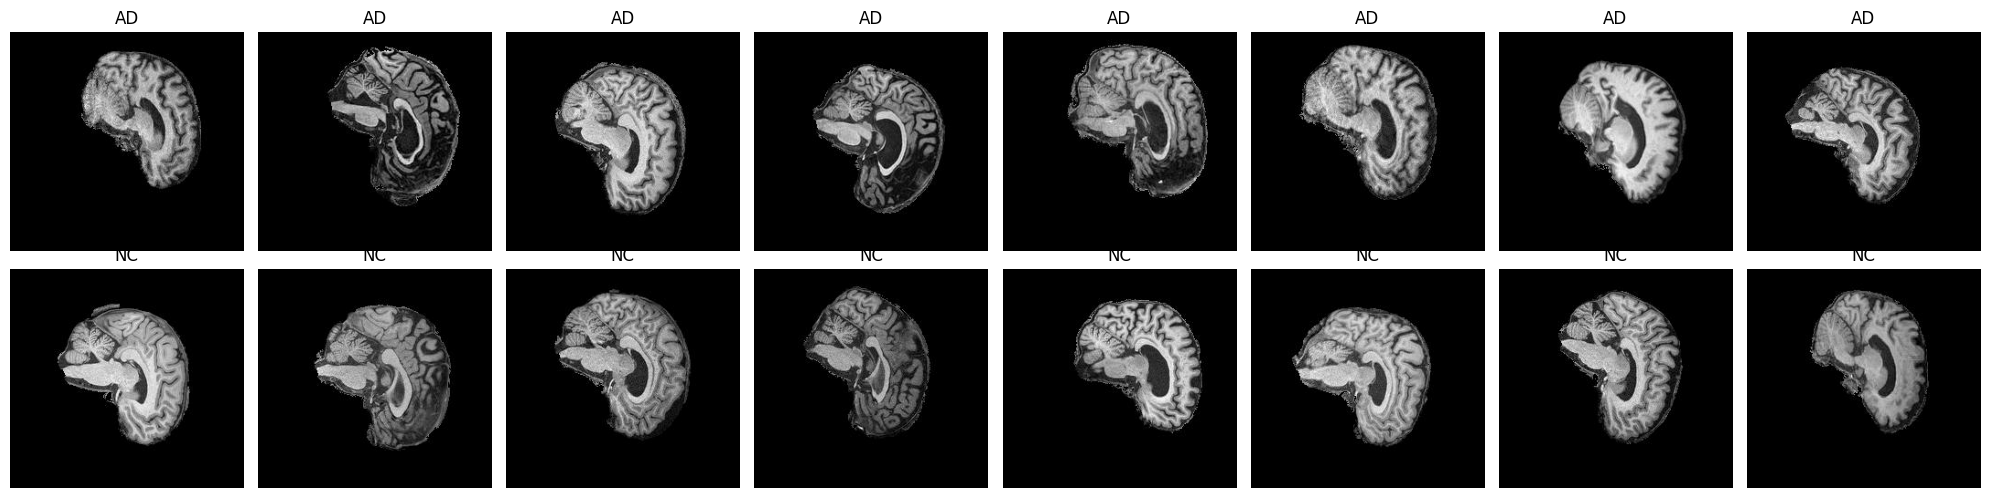

In [34]:
import matplotlib.pyplot as plt
import random

def display_class_images(dataset, num_images=8):
    """
    Displays a grid of images from the dataset. One row per class.
    
    Parameters:
        dataset (ImageFolder): The dataset containing images and labels.
        num_images (int): The number of images to display per class.
    """
    # Shuffle the dataset indices
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    ad_images = []
    nc_images = []

    # Randomly collect num_images for each class (AD = 0, NC = 1)
    for idx in indices:
        image, label = dataset[idx]
        if label == 0 and len(ad_images) < num_images:  # Class 0 (AD)
            ad_images.append(image)
        elif label == 1 and len(nc_images) < num_images:  # Class 1 (NC)
            nc_images.append(image)
        if len(ad_images) >= num_images and len(nc_images) >= num_images:
            break

    # Plotting AD class (0) and NC class (1)
    fig, axs = plt.subplots(2, num_images, figsize=(20, 5))

    for i in range(num_images):
        # AD class (top row)
        axs[0, i].imshow(ad_images[i])
        axs[0, i].set_title('AD')
        axs[0, i].axis('off')

        # NC class (bottom row)
        axs[1, i].imshow(nc_images[i])
        axs[1, i].set_title('NC')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
display_class_images(train_data, num_images=8)


#### Applying basic transformations

#### Data augmentation stuff
- We notice that, the brain is not always center image so naively doing crops and centering could be quite dangerous!!
However, transformers perform better as they look at 16x16 image patches, so cropping it to 224x224 seems like a decent idea. We also see below that there are still
images that are fine with this cropping so yes...

Also, let's do data augmentation to increase generalisation later;
- rotation
- flipping, etc..

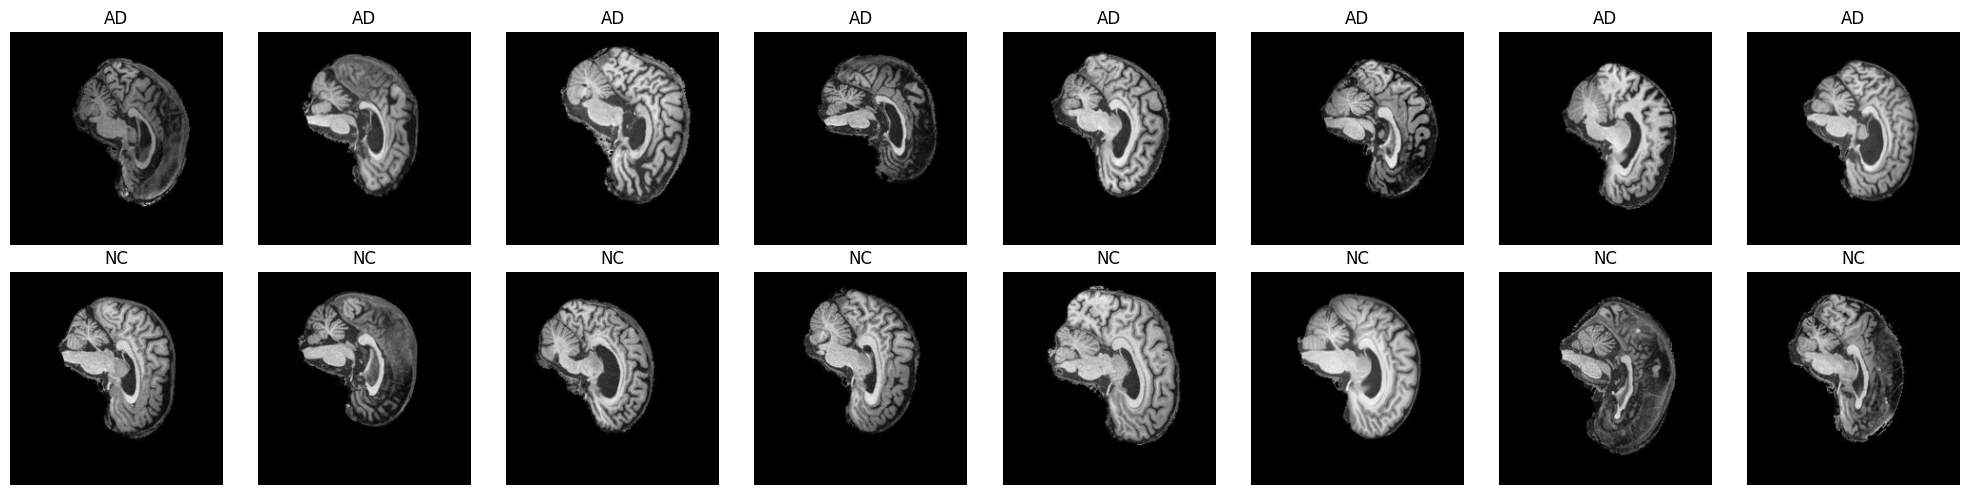

In [35]:
from torchvision import transforms

image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(), # ToTensor converts things into [Channel, Height, Width]
])

train_data = torchvision.datasets.ImageFolder(root= train_dir, transform= data_transforms)
test_data = torchvision.datasets.ImageFolder(root= test_dir, transform = data_transforms)



def display_class_images(dataset, num_images=8):
    """
    Displays a grid of images from the dataset. One row per class.
    
    Parameters:
        dataset (ImageFolder): The dataset containing images and labels.
        num_images (int): The number of images to display per class.
    """
    # Shuffle the dataset indices
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    ad_images = []
    nc_images = []

    # Randomly collect num_images for each class (AD = 0, NC = 1)
    for idx in indices:
        image, label = dataset[idx]
        if label == 0 and len(ad_images) < num_images:  # Class 0 (AD)
            ad_images.append(image)
        elif label == 1 and len(nc_images) < num_images:  # Class 1 (NC)
            nc_images.append(image)
        if len(ad_images) >= num_images and len(nc_images) >= num_images:
            break

    # Plotting AD class (0) and NC class (1)
    fig, axs = plt.subplots(2, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Convert tensor back to image format (H, W, C) for display
        ad_image = ad_images[i].permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
        nc_image = nc_images[i].permute(1, 2, 0).numpy()  # Same for NC

        # AD class (top row)
        axs[0, i].imshow(ad_image)
        axs[0, i].set_title('AD')
        axs[0, i].axis('off')

        # NC class (bottom row)
        axs[1, i].imshow(nc_image)
        axs[1, i].set_title('NC')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
display_class_images(train_data, num_images=8)

In [61]:
### Calculating the mean and std of the dataset!!
from tqdm import tqdm  # Import tqdm for progress tracking
from torch.utils.data import DataLoader
def get_mean_std(loader: DataLoader):
    mean = torch.zeros(3)
    squared_mean = torch.zeros(3)
    N = 0 # Number of batches
    for images, _ in tqdm(loader, desc="Computing mean and std"): 
        # Images are [32, 3, 224, 224]
        
        num_batches, num_channels, height, width = images.shape
        N += num_batches

        mean += images.sum(dim=(0,2,3)) # Mean is size [3], i.e it's the mean sum over each channel [R, G, B]...
        squared_mean += (images ** 2).sum(dim=(0,2,3)) # Accumulate squared mean
    mean /= N * height * width # Divide the summed mean by the number of pixels we've ever seen (i.e mean is on a per pixel basis)

    squared_mean /= N * height * width # Same with squared mean
    
    # Get std
    std = torch.sqrt((squared_mean - mean ** 2)) # Std per pixel
    
    return mean, std

image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = torchvision.datasets.ImageFolder(root= train_dir, transform= data_transforms)

batch_size = 32
loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # Transform it to tensor instead of leaving it as PIL images..
print(len(loader))
mean, std = get_mean_std(loader)
print(mean, std)

## We get mean:tensor([0.1156, 0.1156, 0.1156])
# std: tensor([0.2229, 0.2229, 0.2229])

673


Computing mean and std: 100%|██████████| 673/673 [00:44<00:00, 14.96it/s]

tensor([0.1156, 0.1156, 0.1156]) tensor([0.2229, 0.2229, 0.2229])


## Now we actually do the Dataset Stuff!

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

train_dir = "./ADNI/AD_NC/train"
test_dir = "./ADNI/AD_NC/test"


mean = torch.Tensor([0.1156, 0.1156, 0.1156]) 
std =  torch.Tensor([0.2229, 0.2229, 0.2229])
# Define batch size
batch_size = 32  # You can adjust this based on your GPU memory
num_workers = 4
image_size = 224
train_fraction = 0.9 # What percentage is used for training vs validation (0.9 is 90%).

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(), # For augmentation and better generalisation
    transforms.RandomRotation(degrees=10),  # Random rotation between -10 and +10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # Mean and std from previous cell
])



# Load the full train dataset
train_data = datasets.ImageFolder(root=train_dir, transform=data_transforms)

# Split the train_data into training and validation datasets
train_size = int(train_fraction * len(train_data))  
val_size = len(train_data) - train_size  
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Load the test dataset (no splitting needed for test)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transforms)

# Create DataLoaders for the training, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Val/test dataloaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)  # No need to shuffle validation set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Check dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_data)}")

# Shuffle not needed for test because we aren't training on it. Shuffle is mainly used because, imagine if you had all your 0 classifications in the beginning and the dataloader ate this. You're feeding the NN hundreds of entire "0s" that it's going to backprop in this direction, instead of an 'unbiased sample'. This can affect how well it learns. Shuffling helps better convergence, and generalisation.

Training set size: 19368
Validation set size: 2152
Test set size: 9000


## Model Creation Phase!!

- We need a transformer, basically. A vision transformer
- https://arxiv.org/abs/2010.11929
- https://paperswithcode.com/method/vision-transformer
- 
"""
Source code of parts for the vision transformer (i.e the ML model).
From the paper
https://arxiv.org/pdf/2010.11929, the main idea is to
- Split image into patches
> Apply a sequence of linear embeddings (like, instead of tokens/text, do it on the patches)
And that's the input to the transformer

I.e image patches == tokens. Then we just continue as a normal transformer.

https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html

https://www.akshaymakes.com/blogs/vision-transformer
I.e


1. Create patch embeddings
2.  Pass embedddings through transformer blocks
3. Perform classification

"""

In [9]:
import torch
from torch import nn
from torchinfo import summary

PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)
print(EMBEDDING_DIMS, NUM_OF_PATCHES)

768 196


In [33]:
## For each 16x16 patch, create an embedding vector (embedding layer thing), with size 768.
# I.e each embedding vector is 16x16x768; can be done with a CONV2D layer!! (https://www.akshaymakes.com/blogs/vision-transformer) <--- GOATED
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

## Remember, in_channels is # channels from image.. (3). Out channel is # channels the conv layer will produce (i.e, like 16 or sokmething -- each thing is basically a feature map?)

# https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148
# ==> BASICALLY. Each out channel will have its OWN KERNEL (each kernel for instance is 3x3, and these are where the parameters are being learnt).


#### Pass random image through conv layer and see what happens
random_images, random_labels = next(iter(train_loader))
random_image = random_images[0]
random_image.unsqueeze(0).shape # Unsqueeze just makes it so that it adds the extra dimension (batch dimension, so that we can put it in the conv layer).

torch.Size([1, 3, 224, 224])

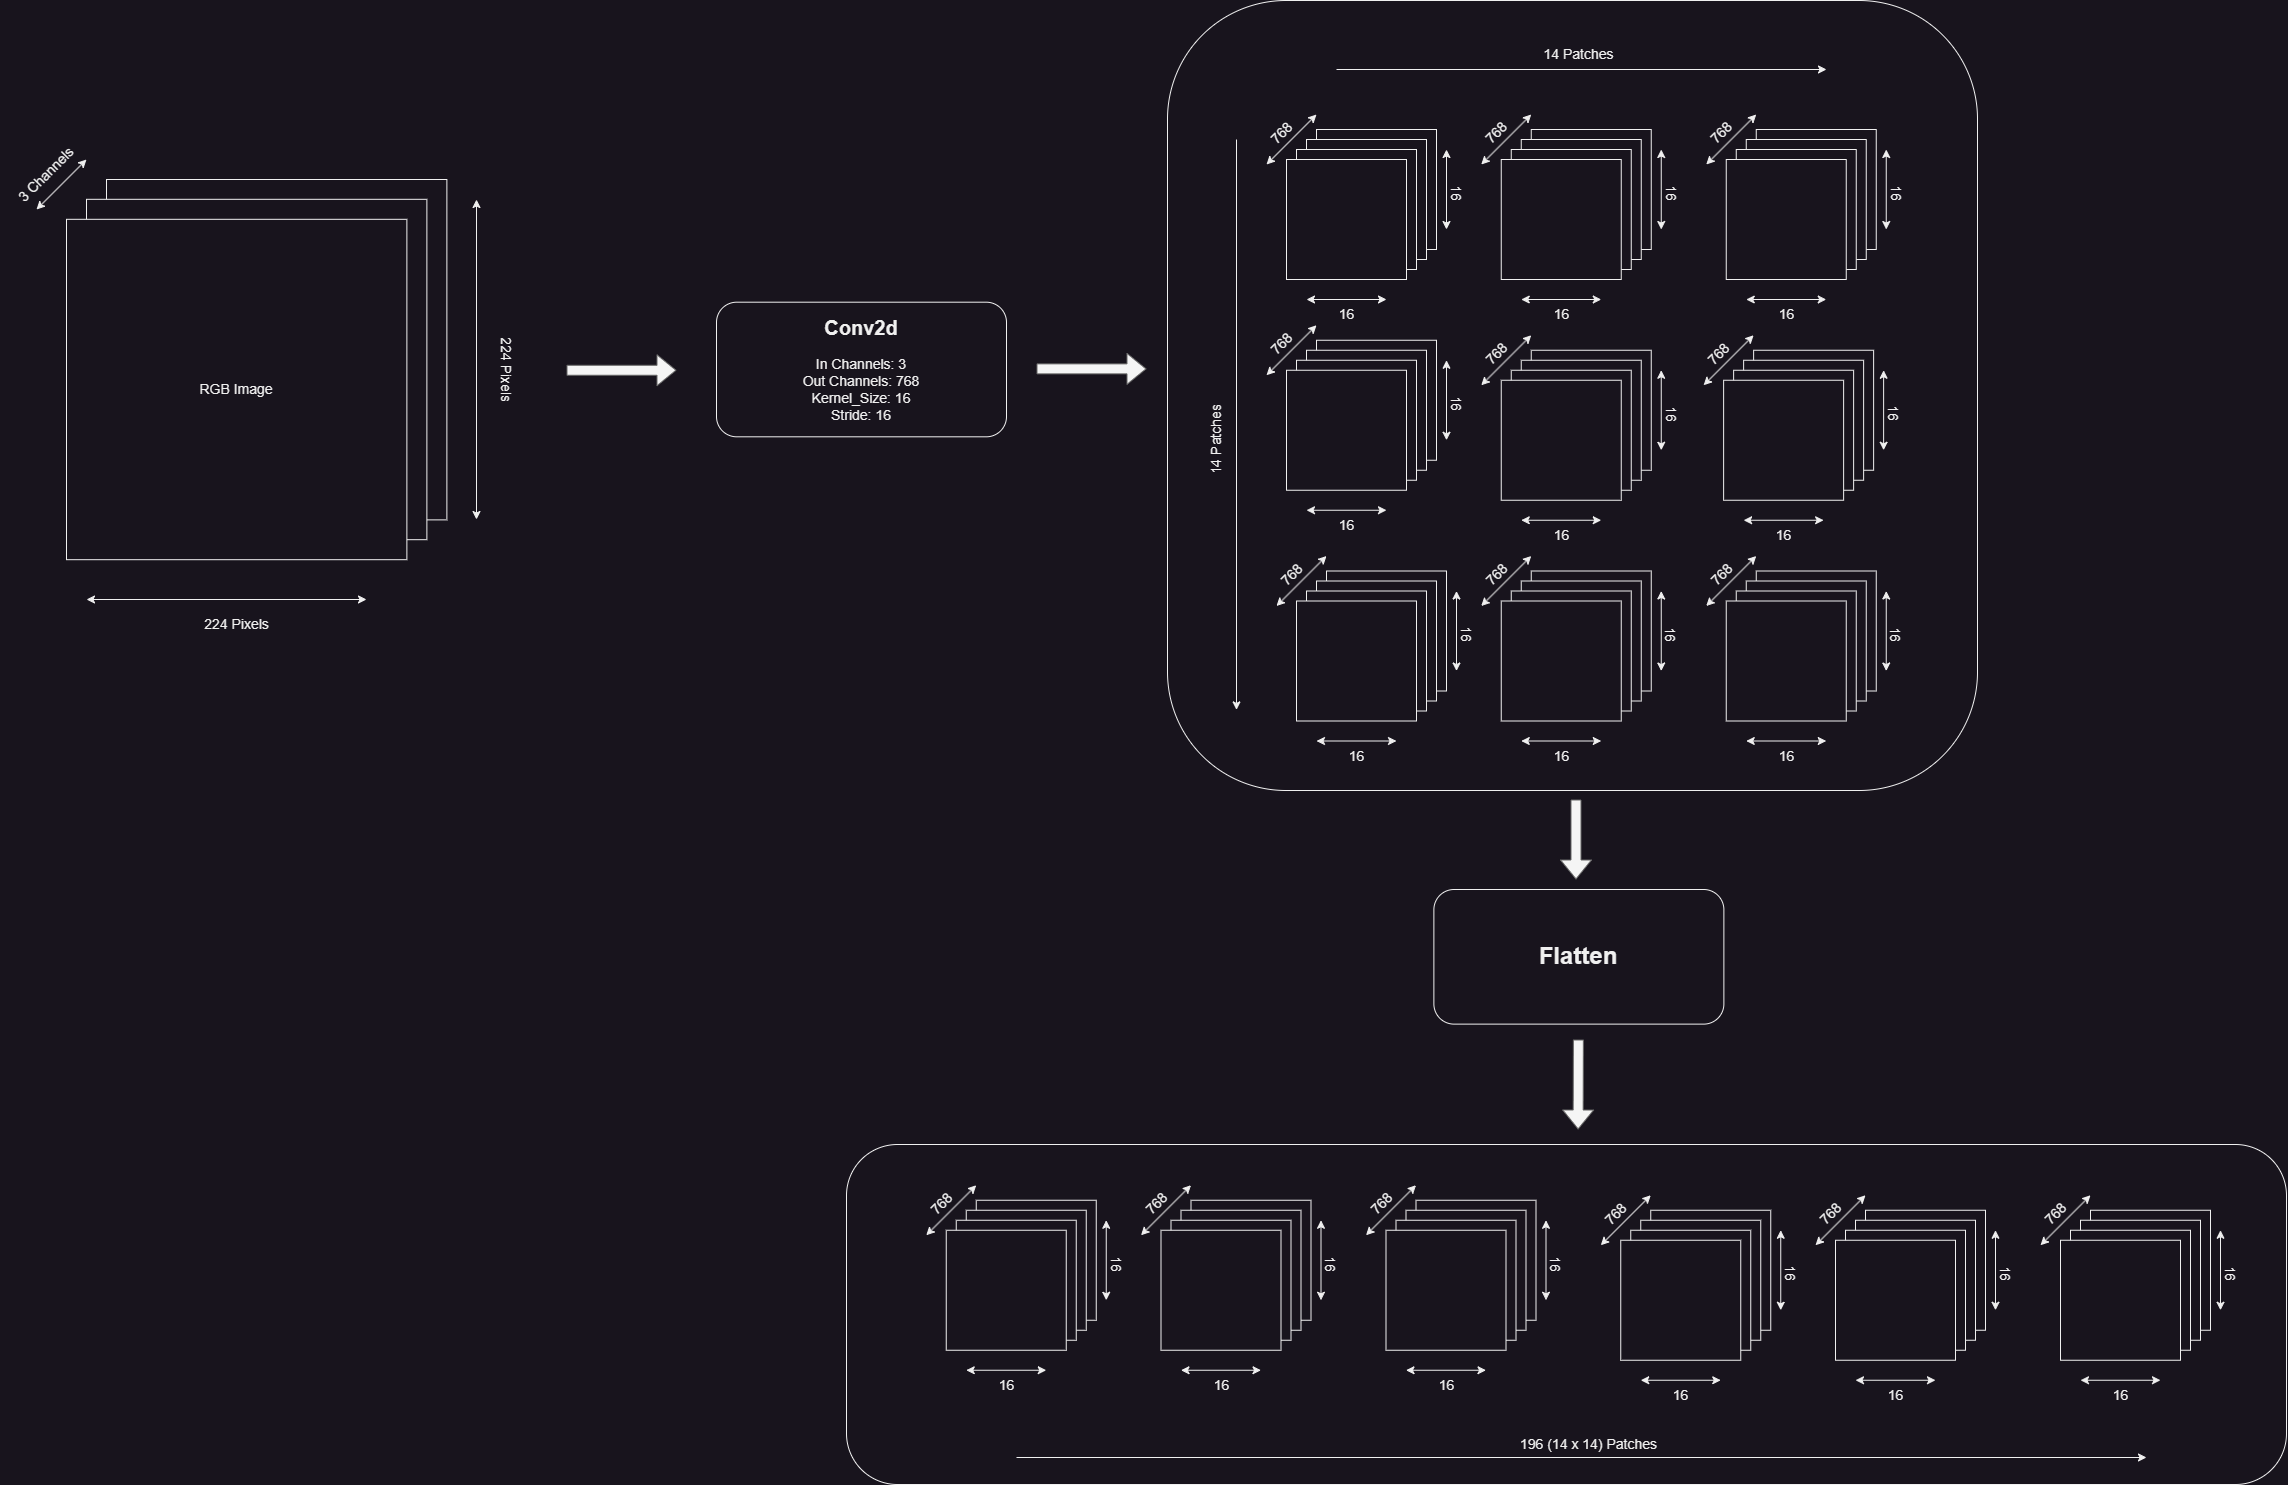

In [34]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {image_through_conv.shape} <- [batch_size, embedding_dims, num_of_patch_rows,num_patch_cols]') 

## We need to convert [1, 768, 14, 14] -> [1, 196, 768].

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1)) # Permute just rearranges the dimension order!!  ==> Now we are going (B, NUM_PATCHROW, NUM_PATCHCOL , EMBEDDING_DIMS)

print(image_through_conv.shape)

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

## THIS GETS YOU THE EMBEDDED VECTOR FOR THAT IMAGE!!
# This has now converted the grid of patches into a single sequence of patches...

Shape of embeddings through the conv layer -> torch.Size([1, 768, 14, 14]) <- [batch_size, embedding_dims, num_of_patch_rows,num_patch_cols]
torch.Size([1, 14, 14, 768])
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]
